In [ ]:
from google.colab import files
files.upload()

Saving DOM_hourly.csv to DOM_hourly.csv


{'DOM_hourly.csv': b'Datetime,DOM_MW\n2005-12-31 01:00:00,9389.0\n2005-12-31 02:00:00,9070.0\n2005-12-31 03:00:00,9001.0\n2005-12-31 04:00:00,9042.0\n2005-12-31 05:00:00,9132.0\n2005-12-31 06:00:00,9353.0\n2005-12-31 07:00:00,9722.0\n2005-12-31 08:00:00,10193.0\n2005-12-31 09:00:00,10586.0\n2005-12-31 10:00:00,10916.0\n2005-12-31 11:00:00,10933.0\n2005-12-31 12:00:00,10698.0\n2005-12-31 13:00:00,10322.0\n2005-12-31 14:00:00,9834.0\n2005-12-31 15:00:00,9503.0\n2005-12-31 16:00:00,9394.0\n2005-12-31 17:00:00,9748.0\n2005-12-31 18:00:00,10973.0\n2005-12-31 19:00:00,11262.0\n2005-12-31 20:00:00,10946.0\n2005-12-31 21:00:00,10728.0\n2005-12-31 22:00:00,10362.0\n2005-12-31 23:00:00,9991.0\n2006-01-01 00:00:00,9649.0\n2005-12-30 01:00:00,9046.0\n2005-12-30 02:00:00,8807.0\n2005-12-30 03:00:00,8843.0\n2005-12-30 04:00:00,8955.0\n2005-12-30 05:00:00,9299.0\n2005-12-30 06:00:00,9960.0\n2005-12-30 07:00:00,10907.0\n2005-12-30 08:00:00,11510.0\n2005-12-30 09:00:00,11630.0\n2005-12-30 10:00:00,1135

In [ ]:
import pandas as pd
df=pd.read_csv("DOM_hourly.csv")

In [ ]:
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


Una serie temporal es una secuencia de puntos de datos numéricos en orden sucesivo. Estos puntos a menudo se miden a intervalos regulares (cada mes, todos los días, cada hora, etc.). La frecuencia de datos utilizada en este artículo es horaria y se midió desde 2004-10-01 hasta 2018-08-03. El número total de puntos de datos sin procesar es 121271.

In [ ]:
# Loading date wrangling package
from datetime import datetime


In [ ]:
# Formating to datetime
df['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['Datetime']]

In [ ]:
# Verificación que no hay datos duplicados
# Si hay algunos duplicados promediamos los datos durante esos días duplicadoss
df = df.groupby('Datetime', as_index=False)['DOM_MW'].mean()


In [ ]:
# Ordenar los valores
df.sort_values('Datetime', inplace=True)

Entonces necesitamos una función que convierta las series temporales en matrices X e Y para que el modelo de aprendizaje profundo comience a aprender. Digamos que queremos crear una función que explique los valores actuales de las series temporales utilizando 3 lags:
Yt = f(Yt₋₁, Yt₋₂, Yt₋₃)

In [ ]:
X = [
[1621.0, 1536.0, 1500.0], # First three lags
[1536.0, 1500.0, 1434.0], # Second three lags
[1500.0, 1434.0, 1489.0], # Third three lags
]
Y = [1434.0, 1489.0, 1620.0]

Este es el truco más importante cuando se utiliza el aprendizaje profundo con series temporales. Puede alimentar estas matrices X e Y no solo a un sistema de red neuronal recurrente (como LSTM) sino a cualquier algoritmo de aprendizaje profundo de vainilla.

In [ ]:

import numpy as np

def create_X_Y(ts: list, lag: int) -> tuple:
    """
    Un método para crear una matriz X e Y a partir de una lista de series temporales para el entrenamiento de 
    modelos de aprendizaje profundo 
    """
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag):
            Y.append(ts[i + lag])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, Y

El modelo de aprendizaje profundo tiene una capa LSTM (que también sirve como capa de entrada) y una capa de salida.

In [ ]:

from keras.models import Sequential
from keras.layers import LSTM, Dense

# Defining the number of neurons in the LSTM layer
n_layer = 50

# Defining how many lags will be used in the time series
n_lag = 3

# Defining the model
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(1))

# The objective functions which will be minimized is mean squared error (mse)
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Data wrangling
import pandas as pd
import numpy as np

# Deep learning: 
from keras.models import Sequential
from keras.layers import LSTM, Dense


class DeepModelTS():
    """
    Una clase para crear un modelo de serie temporal profunda
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

In [ ]:
# Initiating the class
deep_learner = DeepModelTS(
data = df,
Y_var = 'DOM_MW',
lag = 6,
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

Los parámetros de la clase son:
datos- los datos utilizados para el modelado.
Y_var - el nombre de la variable que queremos modelar/pronosticar.
retraso: el número de retrasos utilizados para el modelado.
LSTM_layer_depth - número de neuronas en la capa LSTM.
epochs - número de bucles de entrenamiento (propagación hacia adelante a ciclos de propagación hacia atrás).
batch_size: el tamaño de la muestra de datos para el descenso de gradiente utilizado en el hallazgo de los parámetros por el modelo de aprendizaje profundo. Todos los datos se dividen en trozos de batch_size tamaños y se alimentan a través de la red. Los parámetros internos del modelo se actualizan después de que cada batch_size de datos avanza y retrocede en el modelo.

In [ ]:
# Fitting the model
model = deep_learner.LSTModel()

Epoch 1/10
386/386 [==============================] - 9s 18ms/step - loss: 2515377.2500 - val_loss: 666049.9375
Epoch 2/10
386/386 [==============================] - 4s 10ms/step - loss: 554148.5625 - val_loss: 484796.2812
Epoch 3/10
386/386 [==============================] - 4s 10ms/step - loss: 498237.3750 - val_loss: 619475.2500
Epoch 4/10
386/386 [==============================] - 5s 14ms/step - loss: 475482.9688 - val_loss: 388939.6562
Epoch 5/10
386/386 [==============================] - 4s 11ms/step - loss: 650161.2500 - val_loss: 479349.0938
Epoch 6/10
386/386 [==============================] - 5s 12ms/step - loss: 580021.3750 - val_loss: 489409.9688
Epoch 7/10
386/386 [==============================] - 5s 14ms/step - loss: 486489.8125 - val_loss: 398113.6562
Epoch 8/10
386/386 [==============================] - 4s 9ms/step - loss: 395226.3750 - val_loss: 382077.1875
Epoch 9/10
386/386 [==============================] - 4s 9ms/step - loss: 400464.8750 - val_loss: 409974.0938
Ep

In [ ]:
deep_learner = DeepModelTS(
data = df,
Y_var = 'DOM_MW',
lag = 24, # 24 past hours are used
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)
model = deep_learner.LSTModel()

Epoch 1/10
386/386 [==============================] - 16s 39ms/step - loss: 4032931.2500 - val_loss: 3433458.2500
Epoch 2/10
386/386 [==============================] - 13s 33ms/step - loss: 1944933.6250 - val_loss: 1358839.3750
Epoch 3/10
386/386 [==============================] - 19s 48ms/step - loss: 1890040.1250 - val_loss: 1848937.7500
Epoch 4/10
386/386 [==============================] - 13s 35ms/step - loss: 1588245.2500 - val_loss: 1396258.2500
Epoch 5/10
386/386 [==============================] - 12s 31ms/step - loss: 1171323.3750 - val_loss: 1213344.7500
Epoch 6/10
386/386 [==============================] - 12s 32ms/step - loss: 877468.7500 - val_loss: 655182.8125
Epoch 7/10
386/386 [==============================] - 12s 31ms/step - loss: 480168.7500 - val_loss: 406176.6562
Epoch 8/10
386/386 [==============================] - 12s 32ms/step - loss: 307749.4062 - val_loss: 259345.6250
Epoch 9/10
386/386 [==============================] - 12s 32ms/step - loss: 219986.6875 - val_

In [ ]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = df['DOM_MW'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

i los datos se dividieron en conjuntos de entrenamiento y prueba, entonces el método deep_learner.predict() predecirá los puntos que están en el conjunto de pruebas para ver cómo funciona nuestro modelo fuera de la muestra.

In [ ]:
import matplotlib.pyplot as plt


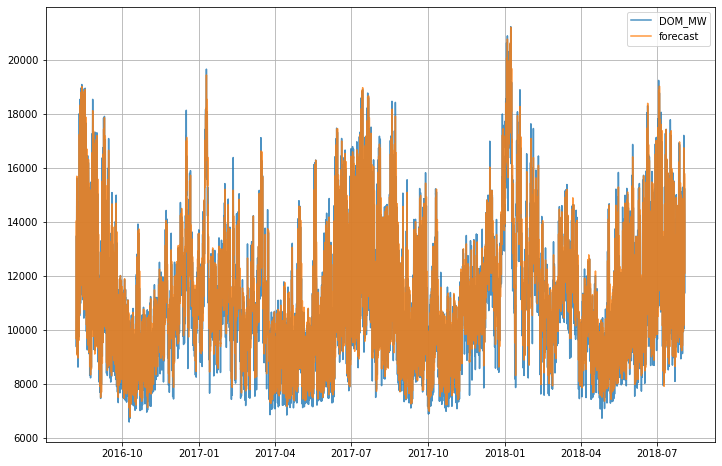

In [ ]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['DOM_MW', 'forecast']:
  plt.plot(
    'Datetime',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()
plt.show()